In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
from datetime import datetime

In [20]:
df_info = pd.read_json('clean_data.json')
df_info.set_index('Id')

,Title,Price,Square,District,City,Date
Id,,,,,,
2113773,Cho thuê phòng trọ tại phường 12 - gò vấp,5500000.0,20.0,Gò Vấp,Hồ Chí Minh,2022-11-17
2112161,"Nhà mới xây, Miễn phí cầu thang máy, điều hòa,...",2800000.0,25.0,Bình Tân,Hồ Chí Minh,2022-11-15
2111349,"Phòng trọ giá rẻ quận 12, đủ 3-4 người ở, có g...",3100000.0,15.0,Quận 12,Hồ Chí Minh,2022-11-14
2111350,Phòng trọ gò vấp có ban công và nội thất chỉ 3...,3600000.0,15.0,Gò Vấp,Hồ Chí Minh,2022-11-14
2111362,"Phòng cho thuê quận Bình Thạnh, đường Ung Văn ...",4000000.0,28.0,Bình Thạnh,Hồ Chí Minh,2022-11-14
...,...,...,...,...,...,...
1269397,"PHÒNG LỚN 35 M2 ĐẦY ĐỦ NỘI THẤT , ĐIỆN NƯỚC R...",3000000.0,35.0,Quận 6,Hồ Chí Minh,2018-12-21
1263796,Cho thuê Ký Túc Xá Phòng Máy Lạnh Cao Cấp ngay...,1600000.0,25.0,Quận 10,Hồ Chí Minh,2018-12-21
1265118,"Phòng trọ 30m2 có gác, sạch sẽ, hẻm xe hơi, tạ...",3200000.0,30.0,Bình Thạnh,Hồ Chí Minh,2018-12-21


Ta nhận thấy rằng các cột có thể tính toán sự phân bố đó là Price, Square, Date, và District. 2 cột Price và Square đã ở dạng số nên có thể tính trực tiếp, còn cột Date phải xử lý.

Với cột Date, ta sẽ không tính trực tiếp mà ta sẽ chuyển nó thành 1 thuộc tính đó là số ngày đăng

In [21]:
#Lấy ngày hôm nay
today =date.today()
today_column = pd.Series(np.full(len(df_info),fill_value = today))
today_column = today_column.astype('datetime64[ns]')
df_info["Num_day"] = (today_column - df_info["Date"]).dt.days
df_info.drop(df_info[df_info["Num_day"] < 0].index,inplace = True)

Ta sẽ tính các giá trị:

    - Tỉ lệ % (từ 0 đến 100) các giá trị thiếu 
    - Giá trị min
    - Giá trị lower quartile (phân vị 25)
    - Giá trị median (phân vị 50)
    - Giá trị upper quartile (phân vị 75)
    - Giá trị max

    

In [22]:
pd.set_option('display.max_columns', None)

num_col_info_df = pd.DataFrame([],index= ["missing_ratio", "min", "lower_quartile", "median", "upper_quartile", "max" ])
col = ['Price','Square','Num_day']

for i in col:
    missing = np.array(df_info[i].isna().sum()*100/len(df_info)) #tinh phan tram gia tri thieu
    distribu = np.nanpercentile(df_info[i],(0,25,50,75,100)) #tinh min,lower,median,upper,max
    data = np.append(missing,distribu)
    num_col_info_df[i] = data.round(1)
num_col_info_df

,Price,Square,Num_day
missing_ratio,3.500000e+00,12.5,0.0
min,0.000000e+00,1.0,10.0
lower_quartile,2.300000e+06,20.0,1279.0
median,3.500000e+06,25.0,1531.0
upper_quartile,4.900000e+06,30.0,1595.0
max,3.000000e+12,350.0,1786.0


Với các cột không phải dạng số: Title, District, City, ta sẽ tính:

- Tỉ lệ % (từ 0 đến 100) các giá trị thiếu 
- Số lượng giá trị khác nhau
- Giá trị xuất hiện nhiều nhất
- Giá trị xuẩt hiện ít nhất

In [23]:
col = ['Title','District','City']
ob_col_info_df = pd.DataFrame([],index = ['missing ratio','num diff value','Most appear','Min appear'])

for i in col:
    missing = np.array(df_info[i].isna().sum()*100/len(df_info)) #tinh phan tram gia tri thieu
    diff_value = len(df_info[i].dropna().unique())
    count_value = df_info[i].dropna().value_counts()
    most_ap = count_value[0]
    least_ap = count_value[-1]
    ob_col_info_df[i] = [missing,diff_value,most_ap,least_ap]
ob_col_info_df

,Title,District,City
missing ratio,0.0,0.0,0.0
num diff value,3402,23,1
Most appear,1,598,3402
Min appear,1,5,3402


Ta sẽ vẽ một vài biểu đồ để xem xét rõ hơn sự phân bố

In [24]:
def draw_chart(df_col,til,x_name,y_name,typechart = 0):
    #Tính tần số và sắp xếp giảm dần
    data_num = df_col.value_counts()

    #Kiểm tra xem có phải là dạng barh không
    if typechart==1:
        plt.barh(data_num.index,data_num.values,height= 0.5)
    else:
        plt.bar(data_num.index,data_num.values)
        
    plt.title(til)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()

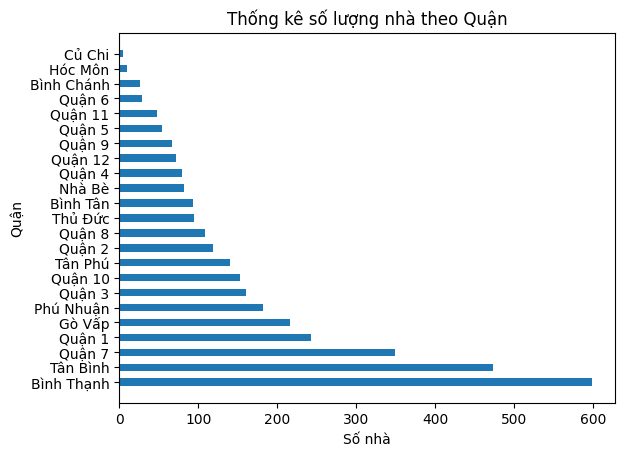

In [25]:
draw_chart(df_info["District"],"Thống kê số lượng nhà theo Quận","Số nhà","Quận",1)

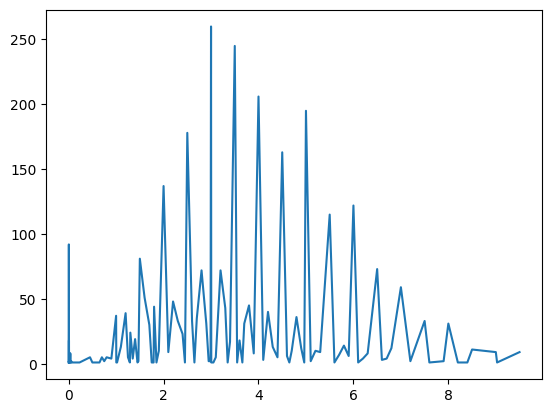

In [26]:
#Chia thành từng khoảng 1 triệu
df_info.drop(df_info[df_info["Price"]>100000000].index,inplace=True)
df_info["Price"] /= 1000000
count_price = df_info[df_info["Price"]<10]["Price"].value_counts()
count_price = count_price.sort_index()
plt.plot(count_price.index,count_price.values)
plt.show()

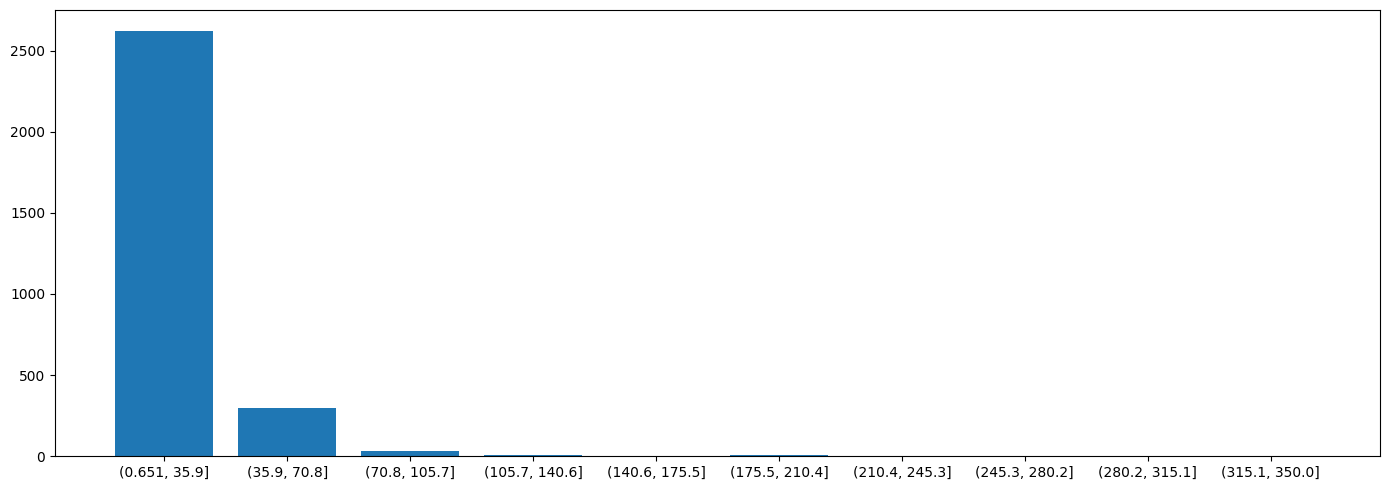

In [69]:
#0 - 350 chia thành bin
a = df_info["Square"].dropna()
b = pd.cut(a.values,bins=10)

c = b.value_counts().sort_index()
c = c.reset_index()
c.columns = ["Range","So luong"]
c["Range"] = c["Range"].astype(str)
plt.subplots(figsize = (14,5))
plt.bar(c["Range"],c["So luong"])
plt.tight_layout()
plt.show()

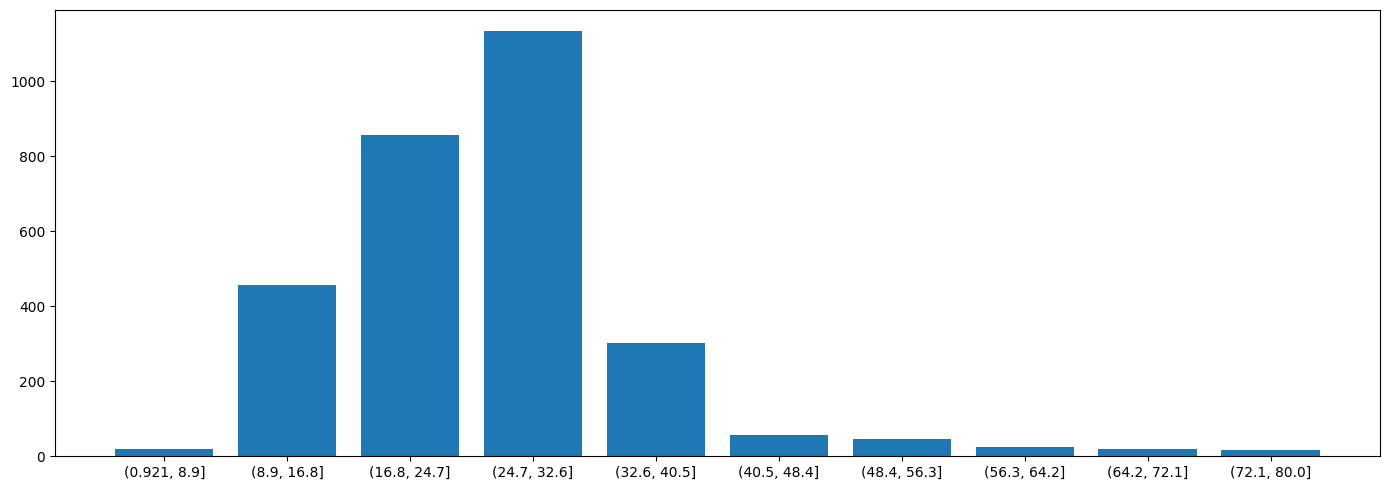

In [72]:
square150 =  df_info[df_info["Square"] <= 80]["Square"]
range_square150 = pd.cut(square150,bins = 10)

count_square150 = range_square150.value_counts().sort_index()
count_square150 = count_square150.reset_index()
count_square150.columns = ["Range","So luong"]
count_square150["Range"] = count_square150["Range"].astype(str)
plt.subplots(figsize = (14,5))
plt.bar(count_square150["Range"],count_square150["So luong"])
plt.tight_layout()
plt.show()

<AxesSubplot: xlabel='Price', ylabel='Square'>

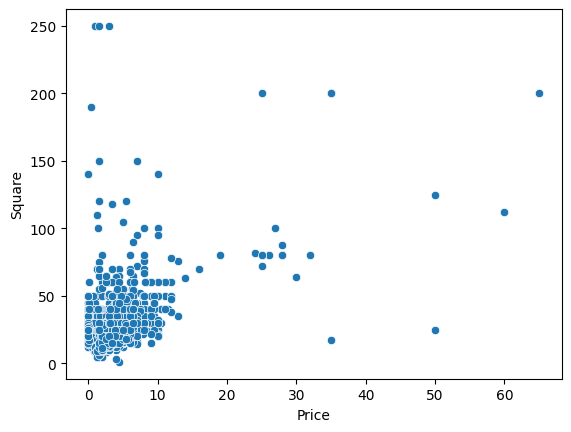

In [79]:
df_data = df_info[["Price","Square"]]
sns.scatterplot(df_data,x = df_data["Price"],y = df_data["Square"])

<AxesSubplot: xlabel='Price', ylabel='Square'>

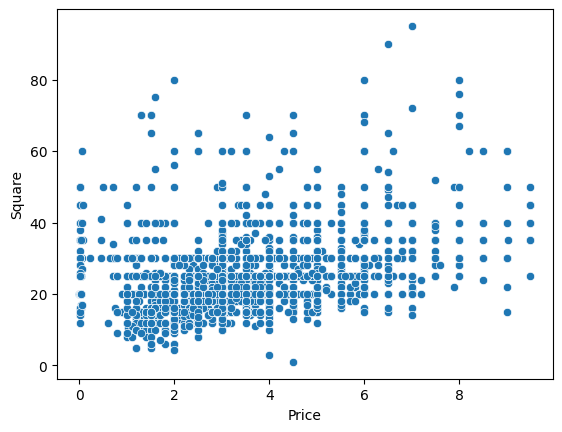

In [81]:
#Ve do thi lien he giua gia va dien tich
df_data = df_info[["Price","Square"]]
df_price_square = df_data[df_data["Price"] < 10]
df_price_square = df_price_square[df_price_square["Square"] < 100]
sns.scatterplot(df_price_square,x = df_price_square["Price"],y = df_price_square["Square"])


Ta thấy giá cả cũng tương đối có mối liên hệ với giá nhà